In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import random
import scipy.sparse.csgraph as sps
import copy
import time
import queue as Q

In [2]:
widgetMat = [
            ['A', 'E', 'D', 'C', 'A'],
            ['B', 'E', 'A', 'C', 'D'],
            ['B', 'A', 'B', 'C', 'E'],
            ['D', 'A', 'D', 'B', 'D'],
            ['B', 'E', 'C', 'B', 'D']]

distanceMat = [
            [0, 1064, 673, 1401, 277],
            [1064, 0, 958, 1934, 337],
            [673, 958, 0, 1001, 399],
            [1401, 1934, 1001, 0, 387],
            [277, 337, 399, 387, 0]]

minDistMat, predMat = sps.dijkstra(distanceMat, return_predecessors=True)

distMatDic = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4}
revDistMatDic = {v: k for k, v in distMatDic.items()}

def calculateMiles(path):
    miles = [distanceMat[distMatDic[path[i]]][distMatDic[path[i+1]]] for i in range(len(path)-1)]
    return sum(miles)
    
def calculateMinMiles(current, path):
    if not current:
        miles = 0
    else: miles = minDistMat[distMatDic[current]][distMatDic[path[0]]]
    miles += sum([minDistMat[distMatDic[path[i]]][distMatDic[path[i+1]]] for i in range(len(path)-1)])
    return miles
    
def maxMiles(current, remainingWidgets):
    maxMiles = 0
    for path in remainingWidgets:
        if path:
            maxMiles = max(maxMiles, calculateMinMiles(current, path))
    return maxMiles

def nonrepeatedOrd(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

def shortestPath(cur, des):
    path = []
    temp = copy.deepcopy(cur)
    while temp != des:
        num = predMat[distMatDic[des]][distMatDic[temp]]
        temp = revDistMatDic[num]
        path.append(temp)
    if cur in path: path.pop(0)
    return nonrepeatedOrd(path)

def widgetGenerator(n):
    random.seed(100)
    widgets = []
    letters = 'ABCDE'
    for i in range(5):
        widget = []
        for j in range(n):
            if j > 0:
                choice = letters.replace(widget[len(widget)-1], "")
                widget.append(random.choice(choice))
            else: widget.append(random.choice(letters))
        widgets.append(widget)
    return widgets

In [3]:
class widgetState():
    def __init__(self, path, remainingWidget):
        self.remainingWidget = remainingWidget
        self.path = path
        self.heuristic = 0
        
    def __eq__(self, widget):
        return self.remainingWidget == widget.remainingWidget and self.path == widget.path
    
    def __lt__(self, widget):
        return self.heuristic < widget.heuristic

#Pick Widget
    def popComp(self, component):
        widgets = []
        for widg in self.remainingWidget:
            if widg:
                widgets.append([x for index, x in enumerate(widg) if index != 0 or x != component])
        return widgets
        
    def printState(self):
        print("widgets:")
        print(self.remainingWidget)
        print("path:")
        print(self.path)
        print("heuristic:")
        print(self.heuristic)

In [4]:
class widgetPlanning():
    
    def __init__(self):
        self.widgetLength = 0
        self.planning = ""
        self.solution = []
        self.nodeExpanded = 0
    
    def printSolution(self):
        miles = calculateMiles(self.solution)
        print("WidgetLength:" + str(self.widgetLength))
        print("Planning:" + str(self.planning))
        print("Route:" + str(self.solution))
        print("RouteLength:" + str(len(self.solution)))
        print("Miles:" + str(miles))
        print("NodeExpanded:" + str(self.nodeExpanded))
        print("----------------------------------------")

    def AStarPlanning_minStops(self, widgetMat):
        queue = Q.PriorityQueue()
        path = []
        visited = []
        nodes = 0
        remainingWidget = widgetMat
        start = widgetState(path, remainingWidget)
        start.heuristic = len(start.path)+len(max(start.remainingWidget,key=len))
        queue.put((start.heuristic, start))
        visited.append(start)
        while not queue.empty():
            current = queue.get()[1]
            nodes += 1
#             current.printState()
            frontList = [path[0] for path in current.remainingWidget if path]
            lastStop = None
            if current.path:
                lastStop = current.path[-1]
            if frontList:
                for stop in set(frontList):
                    if stop != lastStop:
                        path = copy.deepcopy(current.path)
                        path.append(stop)
                        pickWidgets = current.popComp(stop)
                        newState = widgetState(path, pickWidgets)
                        newState.heuristic = len(path)+len(max(pickWidgets,key=len))
                        visited.append(newState)
                        queue.put((newState.heuristic, newState))
            else: 
                self.planning = "AStarMinStopsPlanning"
                self.widgetLength = len(widgetMat[0])
                self.solution = current.path
                self.nodeExpanded = nodes
                self.printSolution()
                return {"path":current.path, "nodeExpanded":len(visited)}
            
    def UCSPlanning_minStops(self, widgetMat):
        queue = Q.PriorityQueue()
        path = []
        visited = []
        nodes = 0
        remainingWidget = widgetMat
        start = widgetState(path, remainingWidget)
        start.heuristic = 0
        queue.put((start.heuristic, start))
        visited.append(start)
        while not queue.empty():
            current = queue.get()[1]
            nodes += 1
#             current.printState()
            frontList = [path[0] for path in current.remainingWidget if path]
            lastStop = None
            if current.path:
                lastStop = current.path[-1]
            if frontList:
                for stop in set(frontList):
                    if stop != lastStop:
                        path = copy.deepcopy(current.path)
                        path.append(stop)
                        pickWidgets = current.popComp(stop)
                        newState = widgetState(path, pickWidgets)
                        newState.heuristic = len(path)
                        visited.append(newState)
                        queue.put((newState.heuristic, newState))
            else: 
                self.planning = "UCSMinStopsPlanning"
                self.widgetLength = len(widgetMat[0])
                self.solution = current.path
                self.nodeExpanded = nodes
                self.printSolution()
                return {"path":current.path, "nodeExpanded":len(visited)}
            
    def AStarPlanning_minMiles(self, widgetMat):
        queue = Q.PriorityQueue()
        path = []
        visited = []
        nodes = 0
        remainingWidget = widgetMat
        start = widgetState(path, remainingWidget)
        start.heuristic = calculateMiles(start.path)+maxMiles(None, start.remainingWidget)
        queue.put((start.heuristic, start))
        visited.append(start)
        while not queue.empty():
            current = queue.get()[1]
            nodes += 1
#             current.printState()
            frontList = [path[0] for path in current.remainingWidget if path]
            lastStop = None
            if current.path:
                lastStop = current.path[-1]
            if frontList:
                for stop in set(frontList):
                    if stop != lastStop:
                        path = copy.deepcopy(current.path)
                        if lastStop:
                            for s in shortestPath(lastStop, stop):
                                path.append(s)
                        else: path.append(stop)
                        pickWidgets = current.popComp(stop)
                        newState = widgetState(path, pickWidgets)
                        newState.heuristic = calculateMiles(path)+maxMiles(None, pickWidgets)
                        visited.append(newState)
                        queue.put((newState.heuristic, newState))
            else: 
                self.planning = "AStarMinMilesPlanning"
                self.widgetLength = len(widgetMat[0])
                self.solution = current.path
                self.nodeExpanded = nodes
                self.printSolution()
                return {"path":current.path, "nodeExpanded":len(visited)}
            
    def UCSPlanning_minMiles(self, widgetMat):
        queue = Q.PriorityQueue()
        path = []
        visited = []
        nodes = 0
        remainingWidget = widgetMat
        start = widgetState(path, remainingWidget)
        start.heuristic = 0
        queue.put((start.heuristic, start))
        visited.append(start)
        while not queue.empty():
            current = queue.get()[1]
            nodes += 1
#             current.printState()
            frontList = [path[0] for path in current.remainingWidget if path]
            lastStop = None
            if current.path:
                lastStop = current.path[-1]
            if frontList:
                for stop in set(frontList):
                    if stop != lastStop:
                        path = copy.deepcopy(current.path)
                        if lastStop:
                            for s in shortestPath(lastStop, stop):
                                path.append(s)
                        else: path.append(stop)
                        pickWidgets = current.popComp(stop)
                        newState = widgetState(path, pickWidgets)
                        newState.heuristic = calculateMiles(path)
                        visited.append(newState)
                        queue.put((newState.heuristic, newState))
            else: 
                self.planning = "UCSMinMilesPlanning"
                self.widgetLength = len(widgetMat[0])
                self.solution = current.path
                self.nodeExpanded = nodes
                self.printSolution()
                return {"path":current.path, "nodeExpanded":len(visited)}

In [5]:
widget = widgetPlanning()
widget.AStarPlanning_minStops(widgetMat)
widget.AStarPlanning_minMiles(widgetMat)

WidgetLength:5
Planning:AStarMinStopsPlanning
Route:['D', 'B', 'A', 'E', 'D', 'C', 'B', 'A', 'C', 'D', 'E']
RouteLength:11
Miles:8746
NodeExpanded:2688
----------------------------------------
WidgetLength:5
Planning:AStarMinMilesPlanning
Route:['D', 'E', 'B', 'E', 'A', 'E', 'D', 'E', 'B', 'E', 'C', 'A', 'E', 'B', 'E', 'D']
RouteLength:16
Miles:5473
NodeExpanded:7484
----------------------------------------


{'nodeExpanded': 18336,
 'path': ['D',
  'E',
  'B',
  'E',
  'A',
  'E',
  'D',
  'E',
  'B',
  'E',
  'C',
  'A',
  'E',
  'B',
  'E',
  'D']}

WidgetLength:3
Planning:AStarMinStopsPlanning
Route:['D', 'A', 'B', 'E', 'C', 'D']
RouteLength:6
Miles:4202
NodeExpanded:73
----------------------------------------
WidgetLength:3
Planning:AStarMinMilesPlanning
Route:['D', 'E', 'A', 'E', 'B', 'E', 'C', 'E', 'D']
RouteLength:9
Miles:2800
NodeExpanded:240
----------------------------------------
WidgetLength:3
Planning:UCSMinStopsPlanning
Route:['D', 'A', 'B', 'E', 'C', 'D']
RouteLength:6
Miles:4202
NodeExpanded:548
----------------------------------------
WidgetLength:3
Planning:UCSMinMilesPlanning
Route:['D', 'E', 'A', 'E', 'B', 'E', 'C', 'E', 'D']
RouteLength:9
Miles:2800
NodeExpanded:573
----------------------------------------
WidgetLength:4
Planning:AStarMinStopsPlanning
Route:['D', 'B', 'C', 'E', 'D', 'A', 'B', 'C', 'E', 'D']
RouteLength:10
Miles:7887
NodeExpanded:1902
----------------------------------------
WidgetLength:4
Planning:AStarMinMilesPlanning
Route:['B', 'E', 'D', 'E', 'C', 'E', 'A', 'E', 'B', 'E', 'C', 'E', 'D']
Route

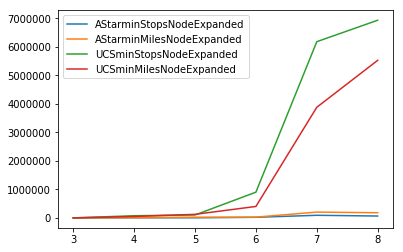

In [6]:
x = np.linspace(3, 8, 6, endpoint=True)
AStarminStopsNodeExpanded = np.zeros(6)
AStarminMilesNodeExpanded = np.zeros(6)
UCSminStopsNodeExpanded = np.zeros(6)
UCSminMilesNodeExpanded = np.zeros(6)  
for n in x: 
        randomWidgetMat = widgetGenerator(int(n))
        AStarminStopsNodeExpanded[int(n)-3] = widget.AStarPlanning_minStops(randomWidgetMat)["nodeExpanded"]
        AStarminMilesNodeExpanded[int(n)-3] = widget.AStarPlanning_minMiles(randomWidgetMat)["nodeExpanded"]
        UCSminStopsNodeExpanded[int(n)-3] = widget.UCSPlanning_minStops(randomWidgetMat)["nodeExpanded"]
        UCSminMilesNodeExpanded[int(n)-3] = widget.UCSPlanning_minMiles(randomWidgetMat)["nodeExpanded"]
plt.plot(x, AStarminStopsNodeExpanded, label="AStarminStopsNodeExpanded")
plt.plot(x, AStarminMilesNodeExpanded, label="AStarminMilesNodeExpanded")
plt.plot(x, UCSminStopsNodeExpanded, label="UCSminStopsNodeExpanded")
plt.plot(x, UCSminMilesNodeExpanded, label="UCSminMilesNodeExpanded")
plt.legend()
plt.show()